Let's start by loading in the data, validating the data, and generating some basic stats.

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('nga_median_spend_model_train_da.csv')

# Drop the index
data = data.drop(columns=["Unnamed: 0"])

# Display the first few rows of the dataset
data.head()

# Basic statistics
#data_stats = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

missing_values

median_spend                           0
lat                                    0
long                                   0
accessibility_to_cities_2015           0
chirps_2015                            0
chirps_average_2002_2015               0
distance_to_ports_2012                 0
distance_to_powerplants_2016           0
distance_to_roads_2015                 0
distance_to_transmission_lines_2016    0
landscan_population_2017               0
modis_evi_2000_2016                    0
modis_lst_day_average_2015             0
modis_lst_night_average_2015           0
modis_ndvi_2000_2016                   0
sedac_gpw_2015                         0
srtm_2000                              0
viirs_nightlights_2015                 0
dtype: int64

No values are missing

Next lets look at the distribution of values for each feature

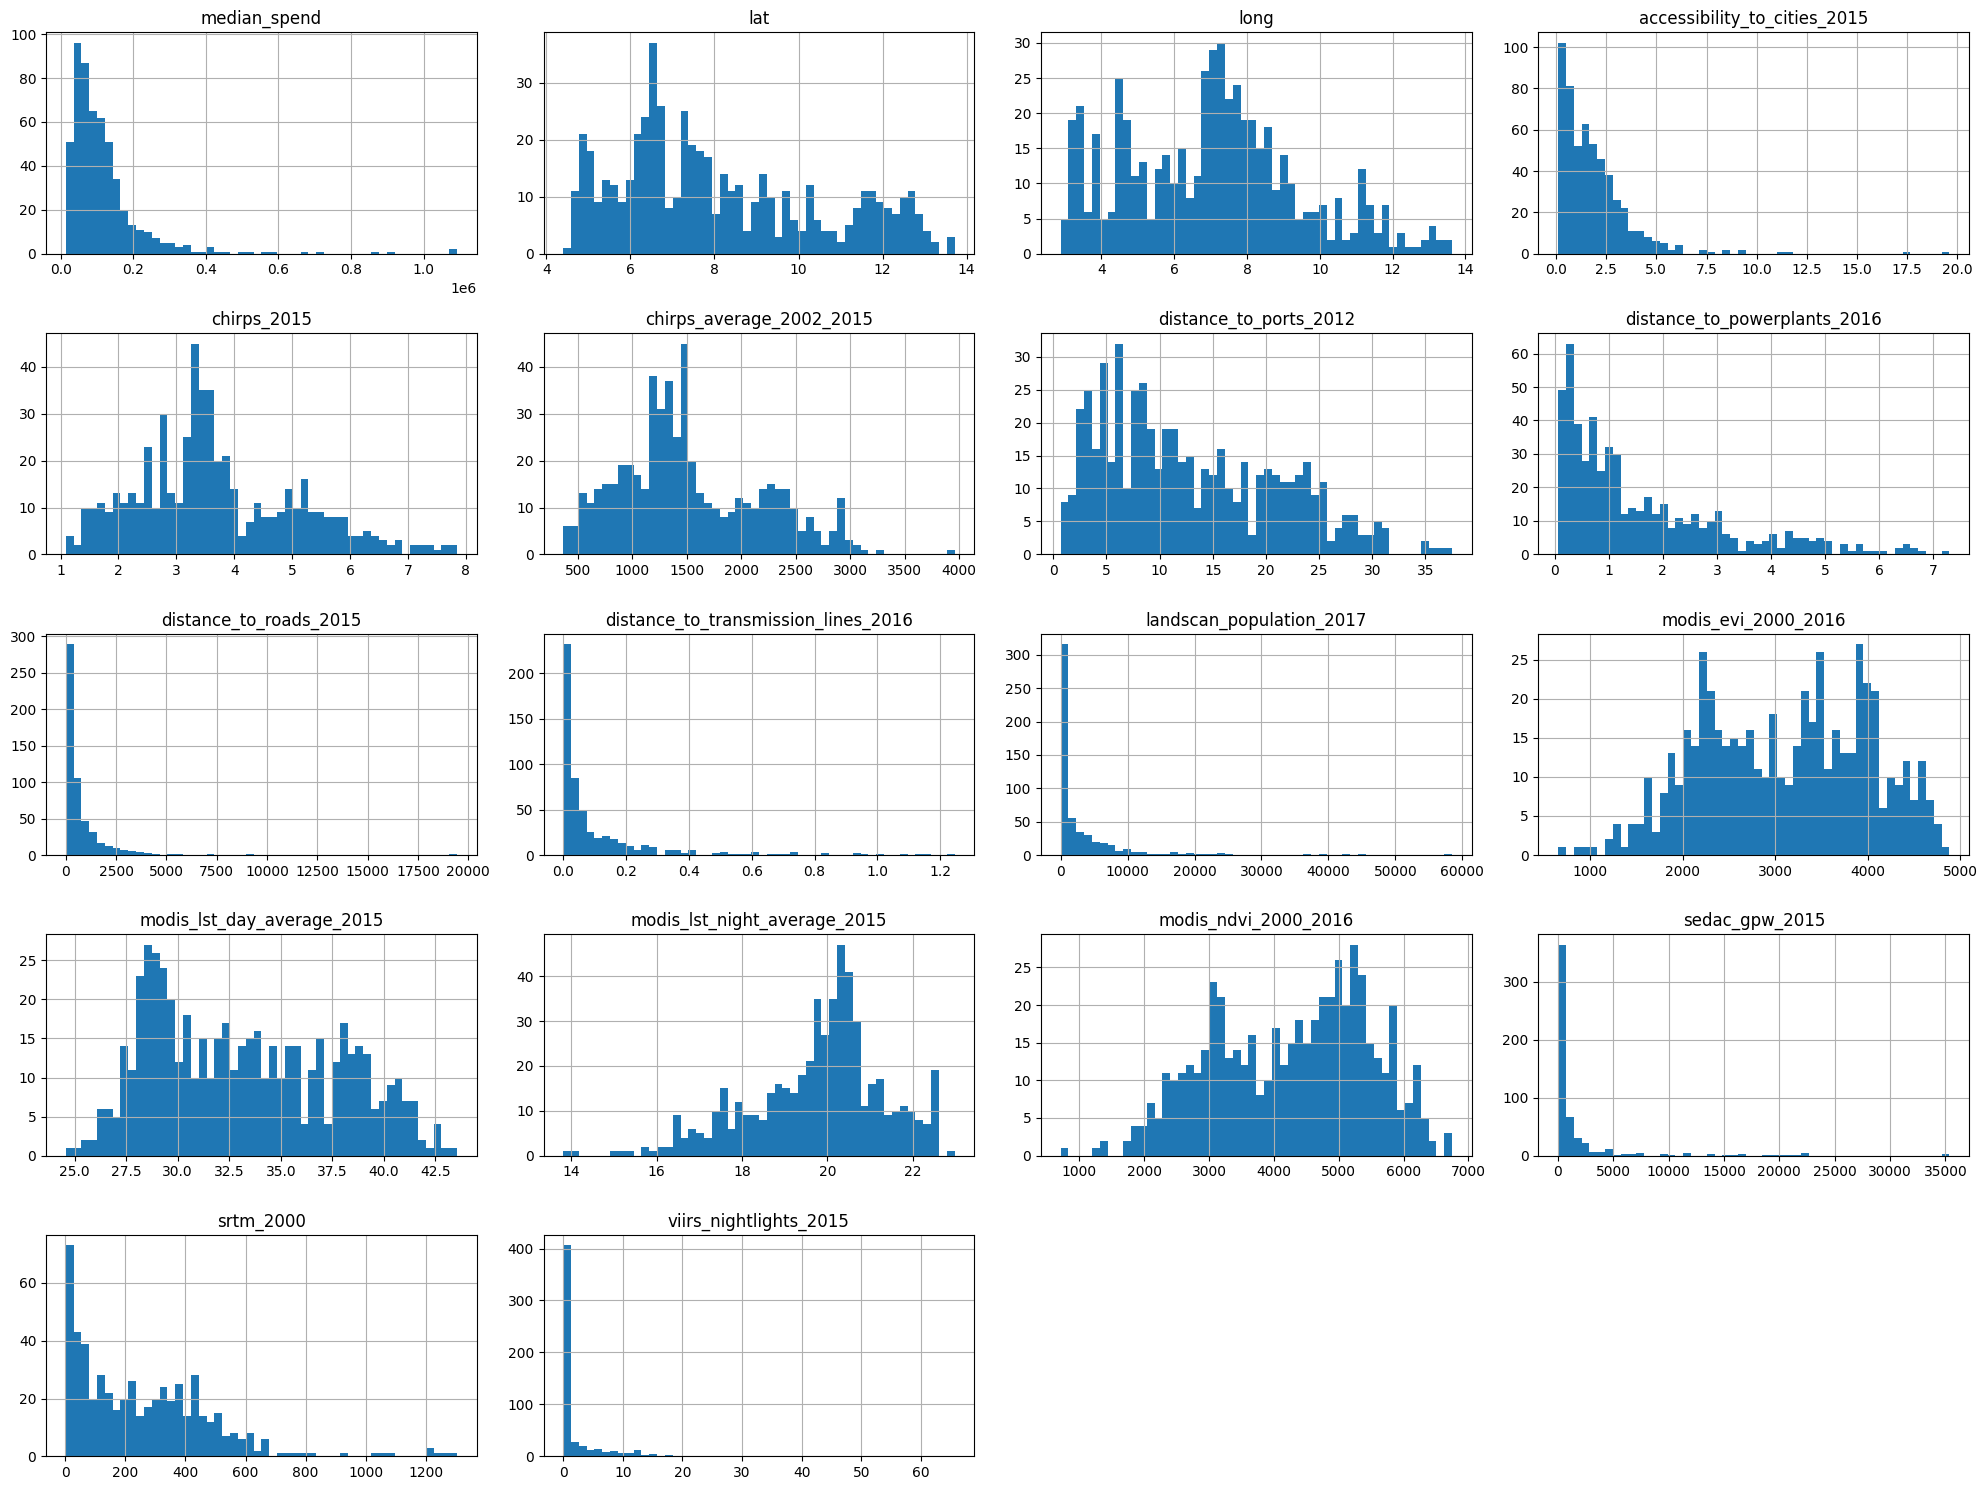

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Histogram for each feature
data.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

Next, let's plot median_spend on a map to see if there are any insights that present themself visually

<ipython-input-4-d2714b56b310>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


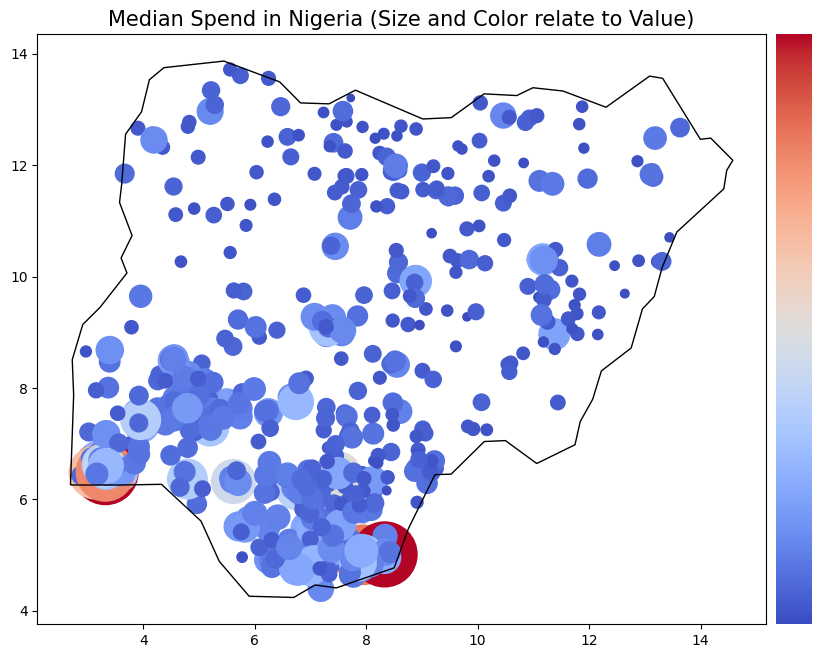

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load Nigeria map (shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select Nigeria
nga = world[world.name == "Nigeria"]

# Create a GeoDataFrame from the data
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.long, data.lat))

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

nga.boundary.plot(ax=ax, linewidth=1, color='black')
gdf.plot(column='median_spend', ax=ax, legend=True, cax=cax, markersize=data['median_spend']/500, cmap='coolwarm', legend_kwds={'label': "Median Spend", 'orientation': "vertical"})

ax.set_title('Median Spend in Nigeria (Size and Color relate to Value)', fontdict={'fontsize': '15', 'fontweight' : '3'})
plt.axis('off')
plt.show()

The map provides some interesting insights:

**Distribution:** The clusters are fairly evenly distributed across Nigeria. There isn't a significant concentration in any specific region, suggesting that the survey was thorough and nationwide.

**Spending:** Higher median spending (represented by larger points) seems to be concentrated more in the southern region of Nigeria. This could be due to factors like higher population densities, more developed infrastructure, and increased access to resources in these areas.

Next we'll make a correlation matrix to identify potentially important features

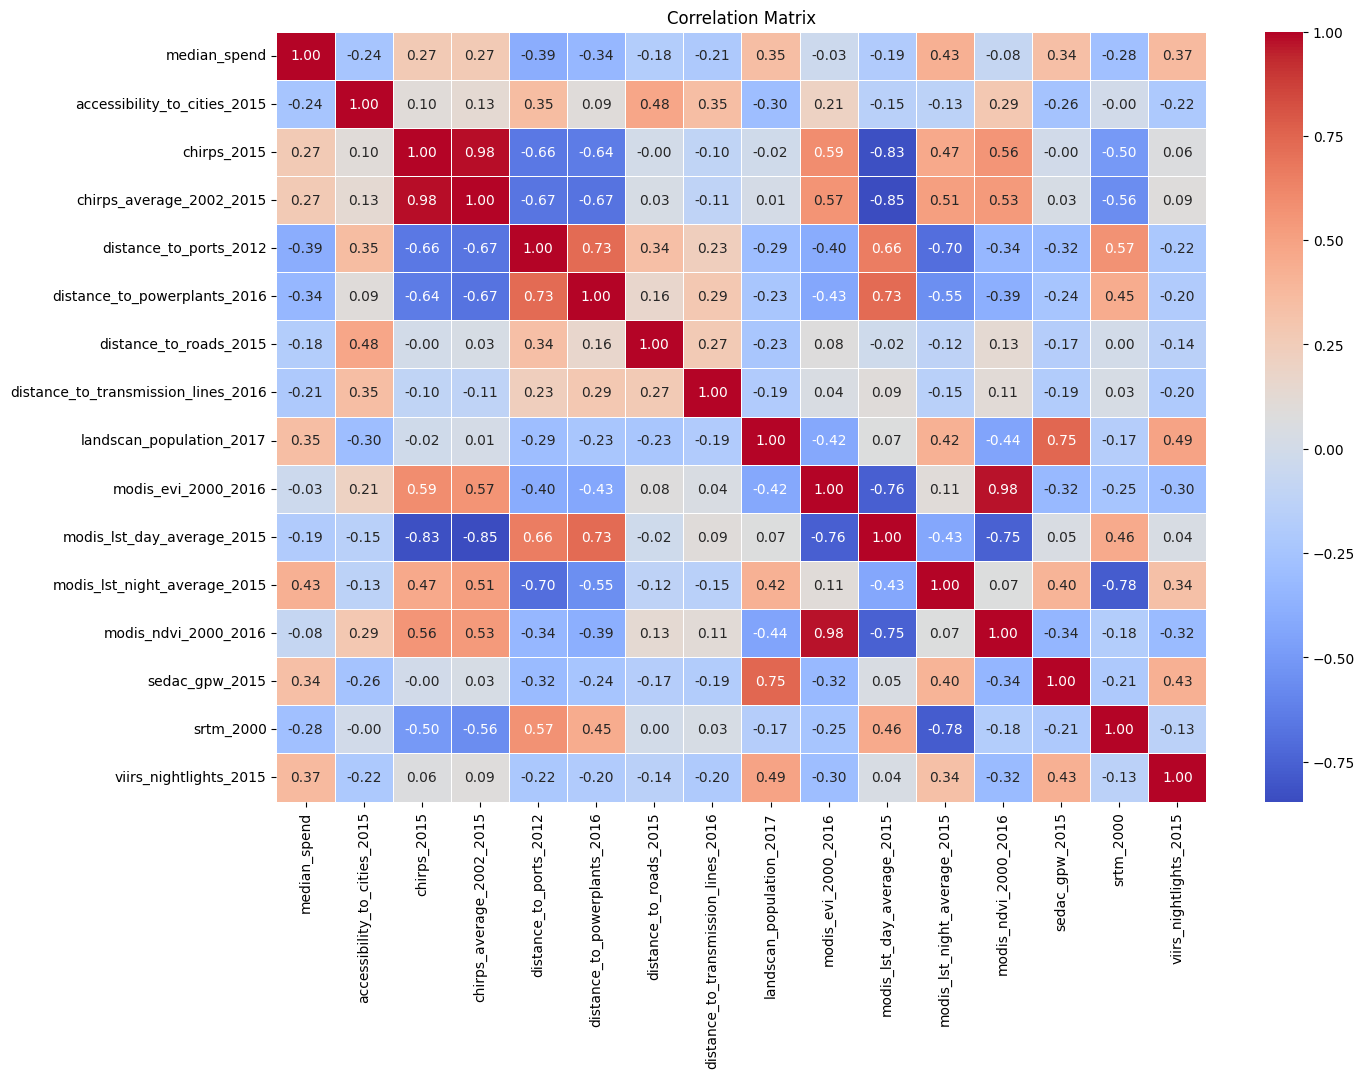

In [5]:
# Drop
data = data.drop(columns=["lat", "long"])

# Correlation matrix
corr_matrix = data.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


At a glance, **landscan_population_2017** has a relatively high positive correlation of 0.27 with **median_spend**, suggesting that clusters with higher population might also have higher median spending.

Nest let's compare results from several different models

I chose Mean Absolute Error (MAE) and the Coefficient of Determination (R^2) as evaluation metrics for these reasons:

Mean Absolute Error (MAE): MAE is a straightforward and easily interpretable metric. It represents the average absolute difference between the predicted and actual values, so a lower MAE indicates better performance. MAE is less sensitive to outliers than some other metrics like Mean Squared Error (MSE), because it doesn't square the differences. This can be beneficial since the data has outliers that we don't want to give too much weight to.

Coefficient of Determination (R^2): R^2 represents the proportion of the variance in the target variable that is predictable from the features. It's a number between 0 and 1, where 1 indicates that the model perfectly predicts the target variable and 0 indicates that the model doesn't predict the target variable at all (beyond the mean of the target variable). Negative values indicate a model that is worse than simply predicting the mean of the target variable. R^2 is a very common metric for regression problems because it gives a sense of how well the features explain variation in the target.

               Model           MAE       R^2
0  Linear Regression  72900.928695  0.212949
1      Decision Tree  86479.497591 -0.240937
2      Random Forest  65853.355066  0.363941
3  Gradient Boosting  65022.061666  0.384481
4              Ridge  72890.161807  0.212226
5              Lasso  72901.366892  0.212945
6         ElasticNet  71189.656291  0.214228
7                SVR  84746.031536 -0.090813
8            XGBoost  68758.266633  0.174283
9          Theil-Sen  69298.900821  0.276810


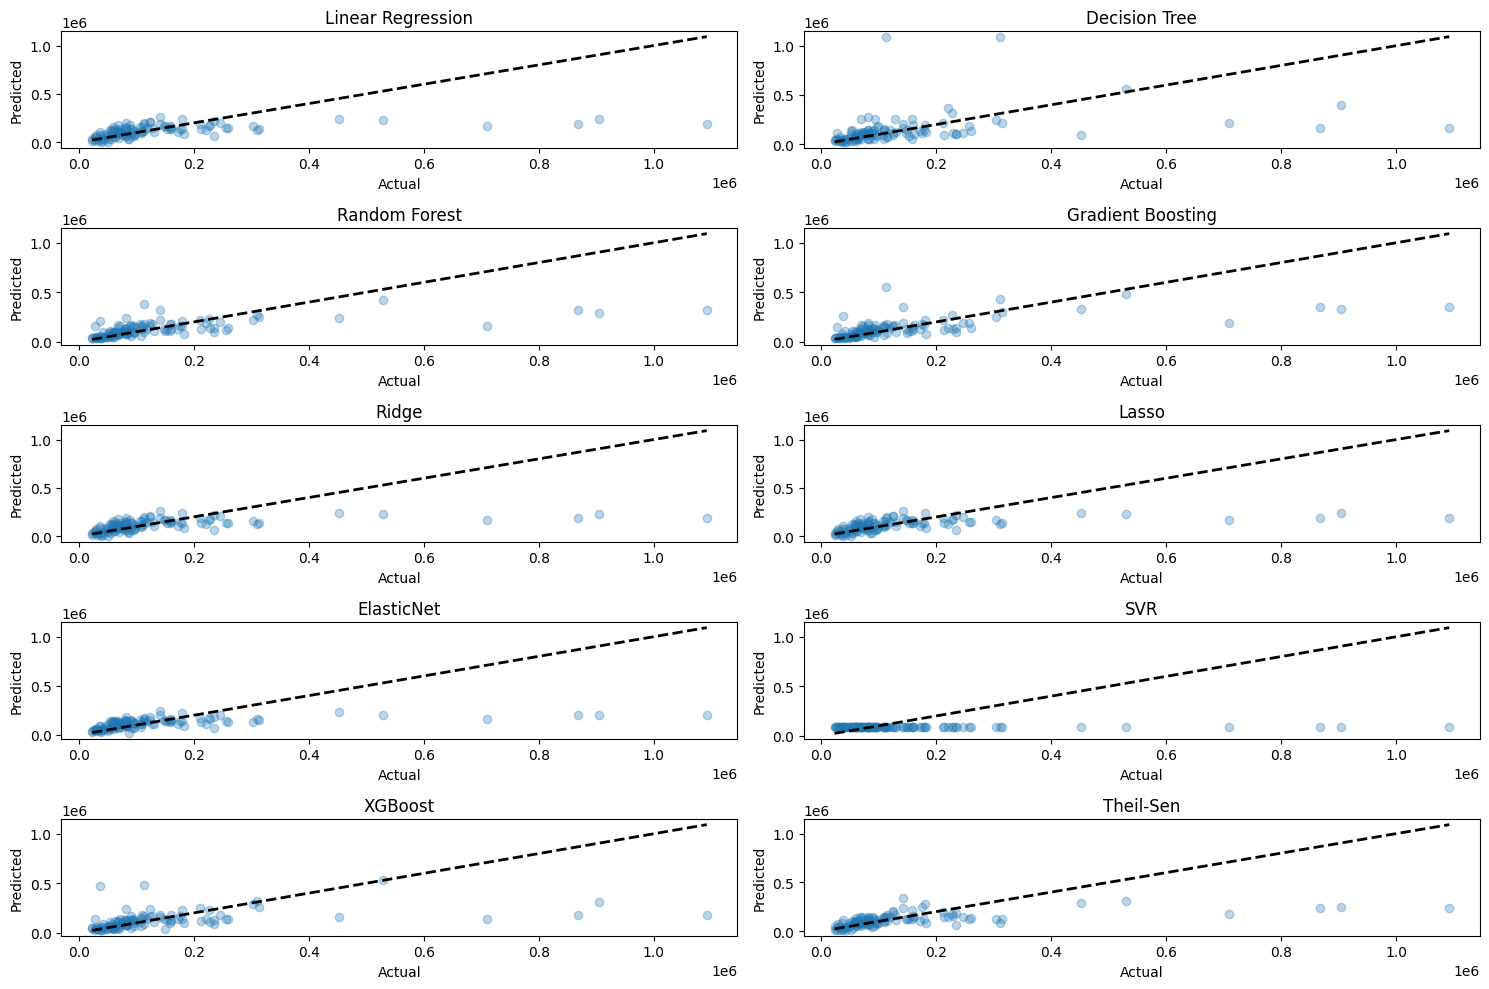

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the features (X) from the target (y)
X = data.drop(columns=["median_spend"])
y = data["median_spend"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the standardized features back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Drop the unnecessary columns
#data = data.drop(columns=["Unnamed: 0", "lat", "long"])

# Check for missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]


from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Initialize the models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("Ridge", Ridge(random_state=42)),
    ("Lasso", Lasso(random_state=42)),
    ("ElasticNet", ElasticNet(random_state=42)),
    ("SVR", SVR()),
    ("XGBoost", XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
    ("Theil-Sen", TheilSenRegressor(random_state=42))

]

# Fit the models and evaluate their performance
results = []

for name, model in models:
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mae, r2))

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Model", "MAE", "R^2"])
print(results_df)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(15, 10))

axs = axs.ravel()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_scaled)

    axs[i].scatter(y_test, y_pred, alpha=0.3)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title(name)

plt.tight_layout()
plt.show()


The results aren't great but let's see if we can improve results by binning similar features to create some new features to use. I decided to bin features into 3 categories, Climate, Distance, and Population Activity.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+11, tolerance: 4.232e+08
  model = cd_fast.enet_coordinate_descent(


               Model           MAE       R^2
0  Linear Regression  72900.928695  0.212949
1      Decision Tree  86326.720644 -0.184547
2      Random Forest  67234.675049  0.350043
3  Gradient Boosting  64238.837428  0.422921
4              Ridge  72895.533425  0.212208
5              Lasso  72900.869203  0.212940
6         ElasticNet  71068.813959  0.217237
7                SVR  84745.619740 -0.090812
8            XGBoost  72243.832763  0.270307
9          Theil-Sen  69634.621330  0.263743


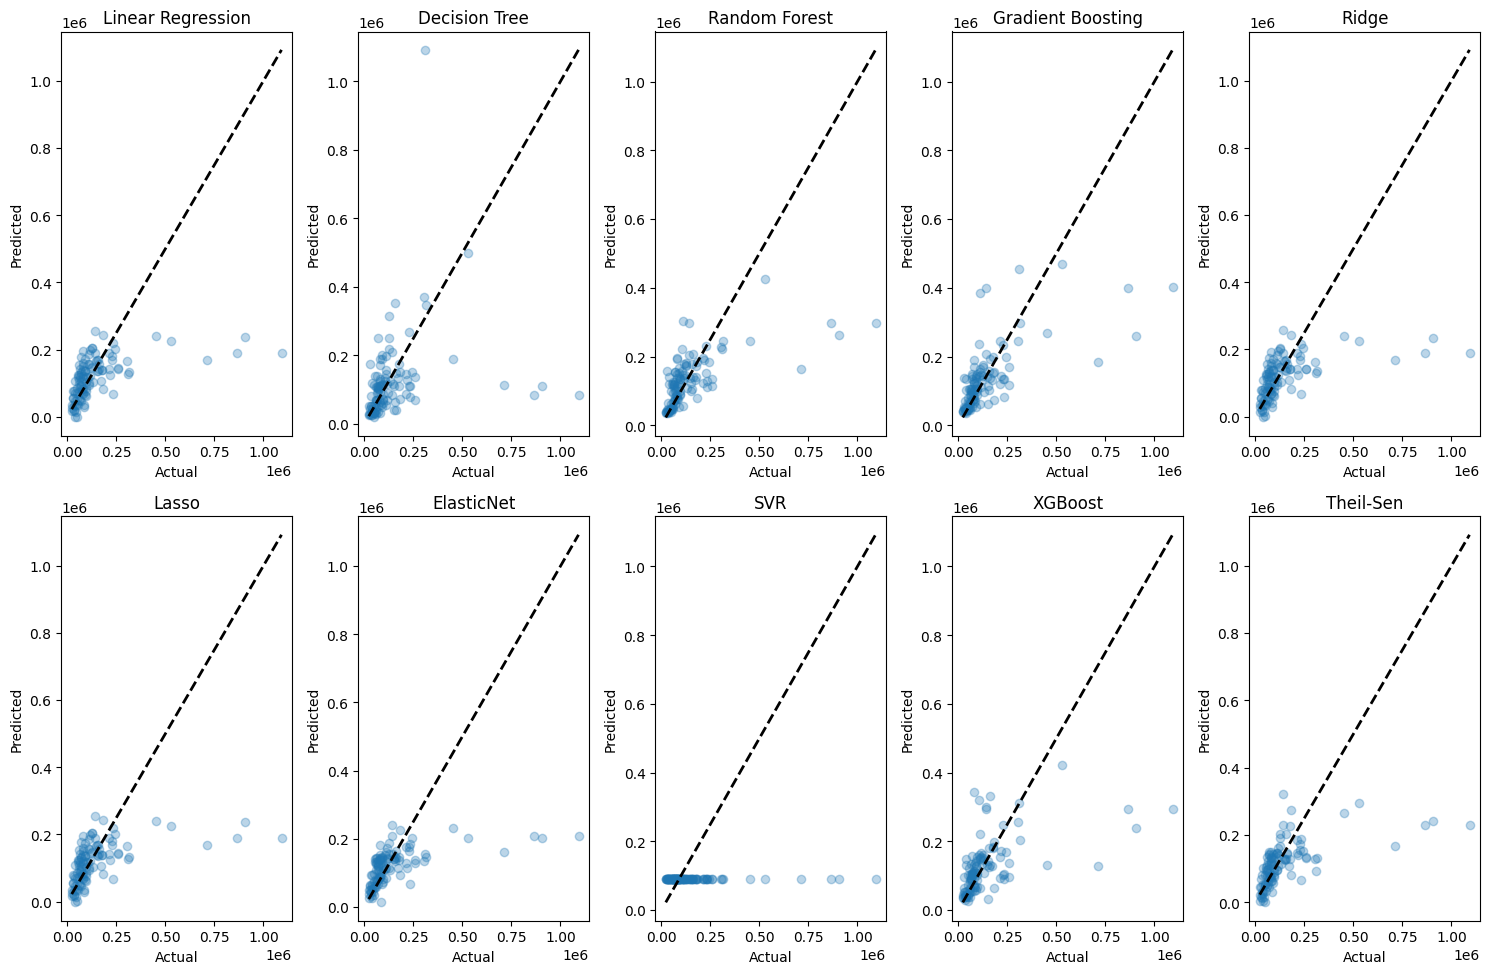

In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# Separate the features (X) from the target (y)
X = data.drop(columns=["median_spend"])
y = data["median_spend"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the standardized features back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Define the feature groups
climate_features = ["chirps_2015", "chirps_average_2002_2015", "modis_evi_2000_2016",
                    "modis_lst_day_average_2015", "modis_lst_night_average_2015",
                    "modis_ndvi_2000_2016", "srtm_2000"]
distance_features = ["accessibility_to_cities_2015", "distance_to_ports_2012",
                     "distance_to_powerplants_2016", "distance_to_roads_2015",
                     "distance_to_transmission_lines_2016"]
population_activity_features = ["landscan_population_2017", "sedac_gpw_2015",
                                "viirs_nightlights_2015"]

# Create the new features
X_train_scaled["climate"] = X_train_scaled[climate_features].mean(axis=1)
X_train_scaled["distance"] = X_train_scaled[distance_features].mean(axis=1)
X_train_scaled["population_activity"] = X_train_scaled[population_activity_features].mean(axis=1)

X_test_scaled["climate"] = X_test_scaled[climate_features].mean(axis=1)
X_test_scaled["distance"] = X_test_scaled[distance_features].mean(axis=1)
X_test_scaled["population_activity"] = X_test_scaled[population_activity_features].mean(axis=1)

# Initialize the models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("Ridge", Ridge(random_state=42)),
    ("Lasso", Lasso(random_state=42)),
    ("ElasticNet", ElasticNet(random_state=42)),
    ("SVR", SVR()),
    ("XGBoost", XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
    ("Theil-Sen", TheilSenRegressor(random_state=42))

]

# Fit the models and evaluate their performance
results = []

for name, model in models:
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mae, r2))

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Model", "MAE", "R^2"])
print(results_df)

fig, axs = plt.subplots(2, 5, figsize=(15, 10))

axs = axs.ravel()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_scaled)

    axs[i].scatter(y_test, y_pred, alpha=0.3)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title(name)

plt.tight_layout()
plt.show()


Comparing these results to the previous ones, we can see that the performance of the Gradient Boosting model has improved significantly, both in terms of MAE and R^2 score. This suggests that the new features we created capture some useful information that helps this model make more accurate predictions.

The performance of the Random Forest model has also improved slightly, while the performances of the Linear Regression and Decision Tree models are approximately the same as before.

We still have some options available to improve performance. Since Gradient boosting performed the best we can try to tune the hyperparameters

In [8]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their values
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize the grid search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the Gradient Boosting model with the best hyperparameters
gb_model_best = GradientBoostingRegressor(**best_params, random_state=42)
gb_model_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = gb_model_best.predict(X_test_scaled)

# Compute the performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

(mae, r2)


(66566.13722264077, 0.3538227257197125)

In this case, tuning resulted in worse performance.

Next we can try to create an ensemble model.

We'll first train the individual Gradient Boosting models and then create a function to make predictions with the ensemble. We'll evaluate the performance of the ensemble using the same metrics as before (MAE and R^2).

 We can fit separate models to the different sets of features (original features, engineered features, and both), and then average their predictions. This is a type of ensemble known as a voting ensemble.

In [9]:
from sklearn.base import clone

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Train a model with only the original features
original_features = list(set(X_train_scaled.columns) - set(["climate", "distance", "population_activity"]))
gb_original = clone(gb_model)
gb_original.fit(X_train_scaled[original_features], y_train)

# Train a model with only the engineered features
engineered_features = ["climate", "distance", "population_activity"]
gb_engineered = clone(gb_model)
gb_engineered.fit(X_train_scaled[engineered_features], y_train)

# Train a model with both the original and engineered features
gb_both = clone(gb_model)
gb_both.fit(X_train_scaled, y_train)

# Define a function to make predictions with the ensemble
def ensemble_predict(X):
    return (gb_original.predict(X[original_features]) +
            gb_engineered.predict(X[engineered_features]) +
            gb_both.predict(X)) / 3

# Make predictions with the ensemble on the test set
y_pred_ensemble = ensemble_predict(X_test_scaled)

# Compute the performance metrics
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

(mae_ensemble, r2_ensemble)


(64598.1645551887, 0.39051793118138023)

We find that the ensemble model performs better than most of the individual models but does not outperform the Gradient Boosting model trained on both the original and engineered features.

There are several strategies that could be explored to further improve the performance of the models:

1. **Feature Engineering**: This includes creating new features from existing ones (like we've done before), but also transforming features (e.g., log-transformation for skewed features), encoding categorical variables, or creating interaction terms.

2. **Feature Selection**: Not all features might be useful for prediction. Unimportant or redundant features can add noise and cause models to overfit. Methods for feature selection include stepwise regression, L1 regularization (Lasso), or using tree-based models for feature importance ranking.

3. **Hyperparameter Tuning**: We've done some hyperparameter tuning using grid search, but there are other methods like random search or Bayesian optimization that can be more efficient. Also, we could consider tuning the hyperparameters of the other models in the ensemble.

4. **Ensemble Methods**: We used a simple voting ensemble, but there are more sophisticated methods like stacking or bagging that might yield better results. We could also consider using different types of models in the ensemble, not just Gradient Boosting.



There are several strategies that could be explored to further improve the performance of the models:


1. **More Complex Models**: We've used fairly standard machine learning models. Depending on the nature of the data, more complex models like neural networks might be able to capture more intricate patterns and improve performance.

2. **Handling of Outliers**: Depending on how outliers are affecting the model performance, different strategies can be adopted. For instance, removing outliers, or applying transformations to decrease the skewness of the data.

3. **Data Scaling**: Some models are sensitive to the scale of the data. We've used standard scaling (z-score normalization), but other methods like min-max scaling or robust scaling might work better depending on the data.

4. **Cross-Validation Strategy**: We've used a simple train-test split, but other strategies like k-fold cross-validation, stratified k-fold, or time-based split might yield more reliable performance estimates.

Each of these options comes with its own trade-offs and considerations, and the effectiveness of each will depend on the specific characteristics of the data and the task.